# CARGAR DATA SET

In [12]:
import math
import operator
import random

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import sympy
from deap import algorithms, base, creator, gp, tools


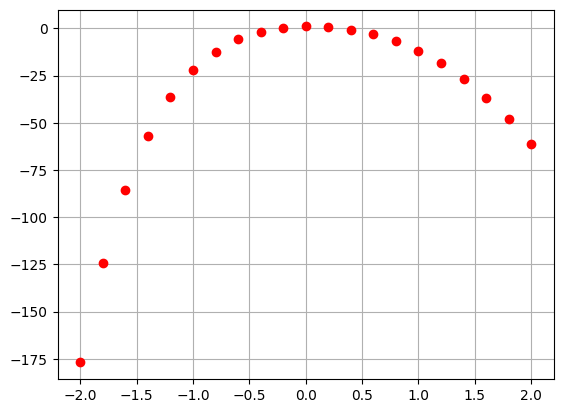

In [13]:

# Cargar el dataset
ruta = '/Users/ferleon/Github/semestre_v/algoritmos_bioinspirados/data/data.xlsx'
df_polar = pl.read_excel(ruta)

df = pl.read_excel(ruta)
x = df['x'].to_numpy()
y = df['y'].to_numpy()
plt.plot(x,y,'ro')
plt.grid()
plt.show()

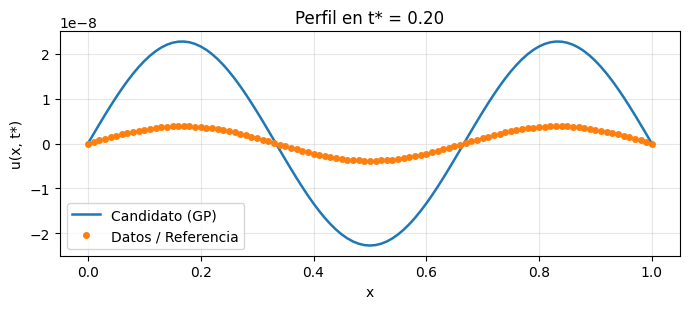

[REF]   MSE(residuo)=1.012e-04  IC=0.000e+00  BC=3.745e-35
[CAND]  MSE(residuo)=1.476e-02  IC=1.990e-04  BC=3.331e-35


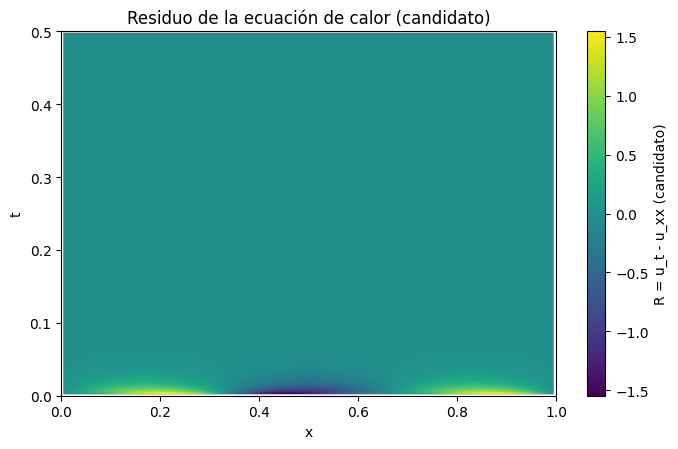

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1) Definir referencia y candidato
# =========================
pi = np.pi

def u_ref(x, t):
    # Solución analítica (sirve como "datos" mientras no tengas medición real)
    return (1.0/5.0) * np.sin(3.0*pi*x) * np.exp(- (3.0*pi)**2 * t)

def u_cand(x, t):
    # Ejemplo de candidato (simula lo que saldría de tu GP)
    # Cambia esto por lo que compile tu GP: u_cand = toolbox.compile(expr=ind)
    return ((1.0/5.0) * np.sin(3.0*pi*x) * np.exp(- 0.9*(3.0*pi)**2 * t)
            + 0.02 * np.sin(6.0*pi*x) * np.exp(- (6.0*pi)**2 * t))

# =========================
# 2) Funciones utilitarias
# =========================
def make_slice_values(u_func, x, t_star):
    # Evalúa una función u(x,t) en una rebanada temporal t = t_star
    x = np.asarray(x)
    return u_func(x, t_star)

def compute_residual_mse(u_func, Nx=201, Nt=201, T_max=0.5):
    # Calcula MSE del residuo R = u_t - u_xx en el interior de la malla
    x = np.linspace(0.0, 1.0, Nx)
    t = np.linspace(0.0, T_max, Nt)
    dx = x[1]-x[0]
    dt = t[1]-t[0]

    # Malla y evaluación
    X, T = np.meshgrid(x, t, indexing='ij')
    U = u_func(X, T)

    # Derivadas centrales (solo interior)
    R = np.full_like(U, np.nan)
    for i in range(1, Nx-1):
        ut  = (U[i, 2:Nt] - U[i, 0:Nt-2]) / (2.0*dt)
        uxx = (U[i+1, 1:Nt-1] - 2.0*U[i, 1:Nt-1] + U[i-1, 1:Nt-1]) / (dx*dx)
        R[i, 1:Nt-1] = ut - uxx

    # MSE interior del residuo
    R_int = R[1:-1, 1:-1]
    mse_res = float(np.nanmean(R_int**2))

    # Penalizaciones sencillas para CI y CB (útiles para fitness del GP)
    u0_target = (1.0/5.0) * np.sin(3.0*pi*x)
    mse_ic = float(np.mean((U[:, 0] - u0_target)**2))
    mse_bc = 0.5 * (float(np.mean(U[0, :]**2)) + float(np.mean(U[-1, :]**2)))

    return {
        "mse_residual": mse_res,
        "mse_IC": mse_ic,
        "mse_BC": mse_bc,
        "grid": (x, t),
        "U": U,
        "R": R
    }

# =========================
# 3) Parámetros de graficado (corte 1D)
# =========================
Nx_slice = 101
x_slice = np.linspace(0.0, 1.0, Nx_slice)
t_star = 0.20  # elige el tiempo de la rebanada

y_red   = make_slice_values(u_ref,  x_slice, t_star)   # "datos" (rojo)
y_blue  = make_slice_values(u_cand, x_slice, t_star)   # candidato (azul)

plt.figure(figsize=(7, 3.2))
plt.plot(x_slice, y_blue, label="Candidato (GP)", linewidth=1.8)  # línea azul por defecto
plt.plot(x_slice, y_red,  'o', label="Datos / Referencia", markersize=4)  # puntos (rojo por defecto en 'o' depende del tema)
plt.xlabel('x')
plt.ylabel('u(x, t*)')
plt.title(f'Perfil en t* = {t_star:.2f}')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# 4) Diagnóstico físico (opcional para el reporte)
# =========================
diag_ref  = compute_residual_mse(u_ref,  Nx=201, Nt=201, T_max=0.5)
diag_cand = compute_residual_mse(u_cand, Nx=201, Nt=201, T_max=0.5)

print(f"[REF]   MSE(residuo)={diag_ref['mse_residual']:.3e}  IC={diag_ref['mse_IC']:.3e}  BC={diag_ref['mse_BC']:.3e}")
print(f"[CAND]  MSE(residuo)={diag_cand['mse_residual']:.3e}  IC={diag_cand['mse_IC']:.3e}  BC={diag_cand['mse_BC']:.3e}")

# Heatmap rápido del residuo del candidato (útil para el profe)
x, t = diag_cand['grid']
R = diag_cand['R'].copy()
R[0, :]=R[-1, :]=np.nan; R[:, 0]=R[:, -1]=np.nan

plt.figure(figsize=(7, 4.6))
im = plt.imshow(
    R.T, origin='lower',
    extent=[x[0], x[-1], t[0], t[-1]],
    aspect='auto'
)
plt.colorbar(im, label='R = u_t - u_xx (candidato)')
plt.xlabel('x'); plt.ylabel('t')
plt.title('Residuo de la ecuación de calor (candidato)')
plt.tight_layout()
plt.show()

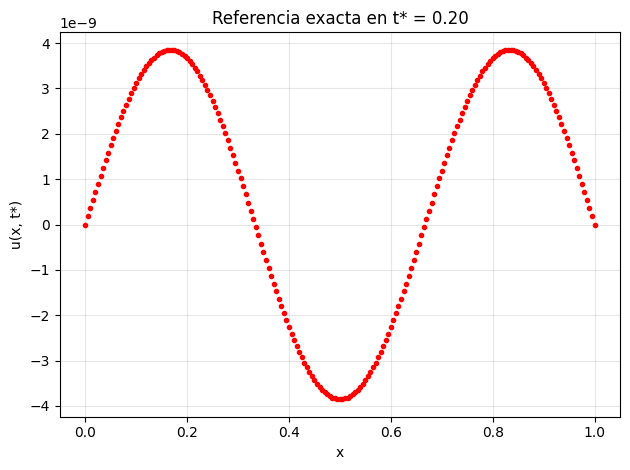

In [18]:
import numpy as np
import matplotlib.pyplot as plt

pi = np.pi

# Solución exacta (vectorizable: acepta escalares o arrays de NumPy)
def u_ref(x, t):
    return (1.0/5.0) * np.sin(3.0*pi*x) * np.exp(-(3.0*pi)**2 * t)

# Muestreo en malla (opcional, por si necesitas el campo completo)
def sample_reference(Nx=201, Nt=201, T_max=0.5):
    x = np.linspace(0.0, 1.0, Nx)
    t = np.linspace(0.0, T_max, Nt)
    X, T = np.meshgrid(x, t, indexing='ij')
    U = u_ref(X, T)
    return x, t, U

# Demo rápido: rebanada en un tiempo fijo t*
x = np.linspace(0.0, 1.0, 201)
t_star = 0.20
y = u_ref(x, t_star)

plt.plot(x, y, 'ro', markersize=3)
plt.xlabel('x'); plt.ylabel('u(x, t*)')
plt.title(f'Referencia exacta en t* = {t_star:.2f}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# FUNCIÓN OBJETIVO

In [14]:
def function(x):
    return x**3 + x**2 + x + 1

# CONJUNTO DE PRIMITIVAS

In [15]:
primitive_set = gp.PrimitiveSet('MAIN', 1) # 1 variable de entrada
primitive_set.addPrimitive(operator.add, 2) # SUMA
primitive_set.addPrimitive(operator.sub, 2) # RESTA
primitive_set.addPrimitive(operator.mul, 2) # MULTIPLICA
primitive_set.addPrimitive(operator.neg, 1)    # NEGACIÓN CAMBIO DE SIGNO
primitive_set.addPrimitive(math.sin, 1)    # SENO
primitive_set.addPrimitive(math.cos, 1)    # COSENO
primitive_set.addEphemeralConstant("rand101", lambda: random.uniform(-1, 1)) # constantes aleatorias entre -1 y 1

# Renombrar variable de entrada
primitive_set.renameArguments(ARG0='x')

# DEFINIR EL TIPO DE FITNESS (minimizar el error)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)


# FUNCION PARA INICIALIZAR INDIVIDUOS Y POBLACION
toolbox = base.Toolbox()

toolbox.register('expr', gp.genHalfAndHalf, pset=primitive_set , min_=1, max_=2) # Generar expresiones
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.expr) # Inicializar individuos
toolbox.register('population', tools.initRepeat, list, toolbox.individual) # Inicializar poblacion


# FUNCION PARA EVALUAR INDIVIDUOS
toolbox.register("compile", gp.compile, pset=primitive_set) # Compilar el individuo

# FUNCION DE EVALUACION
data_points = df_polar['x'].to_list()
valores_objetivo = df_polar['y'].to_list()

def evaluar(individual):
    func = toolbox.compile(expr=individual)
    valores_individuo = [ func(x) for x in data_points ]
    # Calcular el error cuadratico medio
    mse = ((np.array(valores_individuo) - np.array(valores_objetivo))**2).mean()
    return mse,


# MECANISMOS EVOLUTIVOS
toolbox.register("evaluate", evaluar)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=primitive_set)


# SE LIMITA LA PROFUNDIDAD DE LOS INDIVIDUOS
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))


# =================== ALGORITMO EVOLUTIVO ===================
poblacion = toolbox.population(n=300)
hall_of_fame = tools.HallOfFame(1)

# Estadisticas de la evolucion
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)


# Algoritmo evolutivo simple
algorithms.eaSimple(poblacion, toolbox, 0.5, 0.05, 100, stats=stats, halloffame=hall_of_fame, verbose=True)



print("Mejor individuo: ", hall_of_fame[0])
print()



# =================== PARA MEJORAR LA VISUALIZACION DEL INDIVIDUO ===================
x = sympy.symbols('x')


replacements = {
    "add": lambda a,b: a + b,
    "sub": lambda a,b: a - b,
    "mul": lambda a,b: a * b,
    "neg": lambda a: -a,
    "sin": sympy.sin,
    "cos": sympy.cos,
}


expr_str = str(hall_of_fame[0])
expr_sympy = sympy.sympify(expr_str, locals=replacements)

print(f"\nExpresión simbólica: {sympy.simplify(expr_sympy)}")

# Convertir el mejor individuo a una función de Python
func_mejor = toolbox.compile(expr=hall_of_fame[0])
print()



# Comparar con los valores originales
for x,y in zip(data_points, valores_objetivo):
    print(f"x={x:.2f} -> f(x)={y:.4f} | individuo(x)={func_mejor(x):.4f}")



gen	nevals	avg   	std    	min    	max    
0  	300   	3250.1	67.6895	2850.85	3635.12
1  	184   	3212.85	64.9558	2850.85	3495.38
2  	172   	3192.44	69.1102	2850.85	3478.68
3  	165   	3160.77	78.7785	2850.85	3444.14
4  	169   	3135.9 	118.612	2644.41	3657.35
5  	144   	3069.76	141.063	2644.41	3657.35
6  	167   	3028.99	333.569	2391.18	7178.06
7  	141   	2976.42	334.608	1375.04	4587.38
8  	178   	2915.32	447.308	1375.04	5365.97
9  	150   	2729.33	465.707	1375.04	6017.27
10 	154   	2605.11	626.576	1276.91	6268.95
11 	177   	2445.2 	1086.83	750.268	12464.9
12 	157   	2100.96	840.138	706.914	7613.06
13 	137   	1988.65	1650.2 	615.414	17480.1
14 	181   	2099.95	4620.49	430.387	56168.7
15 	168   	1534.47	3659.12	406.694	52620.5
16 	168   	1145.51	1094.71	412.5  	8815.26
17 	161   	1337.81	3147.41	400.23 	44074.4
18 	159   	1138.51	1562.53	209.119	17968.3
19 	183   	1250.16	2299.83	209.119	22596  
20 	159   	978.227	3216.94	203.839	53553.4
21 	166   	1458.75	3818.99	97.4291	37667.5
22 	154   	96

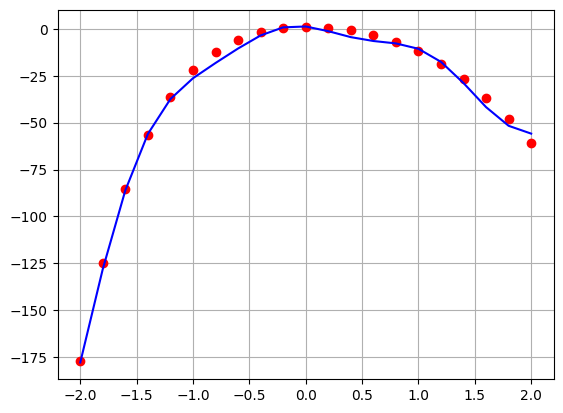

In [16]:




x = df['x'].to_numpy()
y = df['y'].to_numpy()


# Datos aproximados por el mejor individuo
y_aprox = [func_mejor(xi) for xi in x]


plt.plot(x,y,'ro')
plt.plot(x,y_aprox,'b-')
plt.grid()
plt.show()


